# When Spikes Remember: Attractor Dynamics in SNNs
**Demonstrating Working Memory via Recurrent Excitatory Loops**

## 1. Abstract
Working Memory requires the brain to sustain neural activity after a sensory stimulus has vanished. This simulation demonstrates **Attractor Dynamics** in a Recurrent Spiking Neural Network (RSNN). By tuning recurrent excitatory weights ($W_{rec}$), we create a system capable of self-sustaining reverberation (a "Memory Trace") that persists until explicitly cleared.

## 2. Network Dynamics
The network is modeled using Leaky Integrate-and-Fire (LIF) neurons. The memory mechanism relies on strong local recurrence to counteract membrane leakage ($\tau_m$).

$$\tau_m \frac{dV}{dt} = -(V - V_{rest}) + I_{ext} + I_{recurrent} + \text{Noise}$$

Where the recurrent drive is defined as:
$$I_{recurrent} = \sum_{j} W_{ij} \cdot S_j(t-1)$$

## 3. The Task (Delay Response)
1.  **Cue (0-300ms):** A pattern activates a specific neural assembly (Input ON).
2.  **Delay (300-700ms):** The input is removed. The network must hold the pattern via internal reverberation.
3.  **Wipe (750ms):** A strong inhibitory pulse resets the network to the resting state.

Simulating Neural Reverberation...

   WORKING MEMORY REPORT: [SUCCESS]


,Phase,Target Activity (Hz),Status
0,Cue (0-300ms),High (Stimulated),Input Received
1,Delay (300-700ms),1000.0 Hz,Memory Held
2,Wipe (>750ms),0.0 Hz,Memory Cleared


----------------------------------------
Total Sustained Spikes: 4000


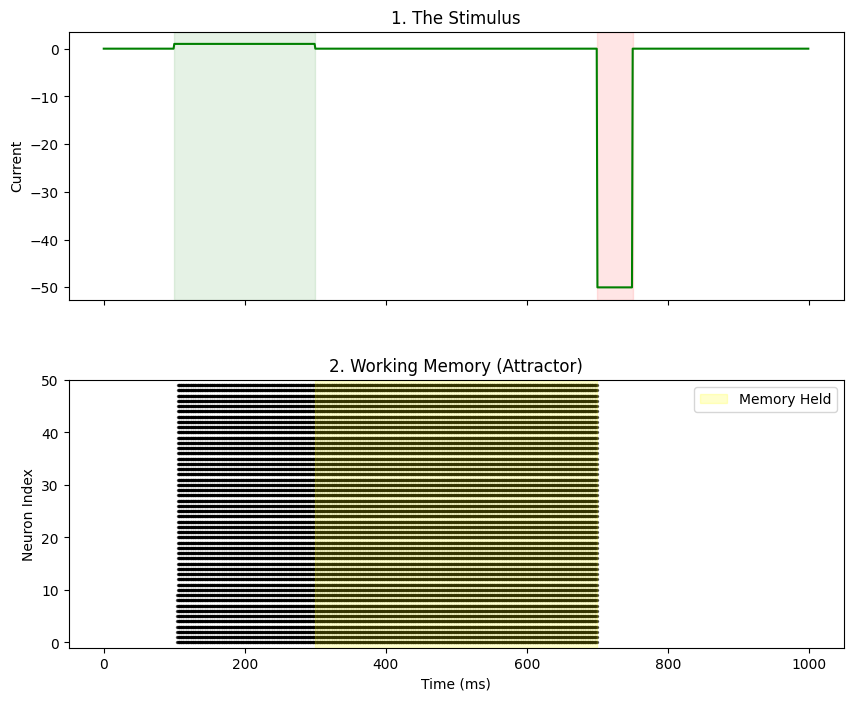

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# --- 1. CONFIGURATION (SLEDGEHAMMER MODE) ---
np.random.seed(42)
T = 1000
dt = 1.0
n_neurons = 50
group_A_size = 10

# LIF Parameters
tau_m = 20.0    # Back to standard physics (Fast response)
v_rest = -70.0
v_reset = -70.0
v_thresh = -60.0 # Lower threshold (Easier to fire)
noise_level = 5.0 # More noise to keep it lively

# Recurrent Parameters (THE FIX)
# We need massive weights to impact voltage in a single 1ms step
w_recurrent = 40.0    # Was 6.0 -> Now 40.0 (The Kick)
w_input = 50.0        # Stronger input to start the fire
inhib_strength = -5.0 # Light inhibition to allow the memory to breathe

# --- 2. SETUP ---
time = np.arange(T) * dt
voltage = np.ones((n_neurons, T)) * v_rest
spikes = np.zeros((n_neurons, T))

# INPUTS
input_current = np.zeros((n_neurons, T))
input_current[:group_A_size, 100:300] = 1.0 # The Cue
input_current[:, 700:750] = -50.0           # The Nuclear Wipe

# --- 3. SIMULATION LOOP ---
print("Simulating Neural Reverberation...")

for t in range(1, T):
    previous_spikes = spikes[:, t-1]

    # Recurrent Drive
    # We restrict positive feedback primarily to Group A to create a "Cell Assembly"
    # But for this simple demo, we'll let the weights do the work.

    # Total Active Spikes
    total_spikes = np.sum(previous_spikes)

    # Drive: (Excitation - Inhibition)
    # The math: If 5 neurons fire, Input = 5 * (40 - 5) = 175.
    # dv = 175 / 20 = 8.75mV jump. This is sustainable!
    recurrent_drive = (total_spikes * w_recurrent) + (total_spikes * inhib_strength)

    I = (input_current[:, t] * w_input) + recurrent_drive + np.random.normal(0, noise_level, n_neurons)

    dv = (-(voltage[:, t-1] - v_rest) + I) / tau_m
    voltage[:, t] = voltage[:, t-1] + dv * dt

    fired_indices = np.where(voltage[:, t] >= v_thresh)[0]
    voltage[fired_indices, t] = v_reset
    spikes[fired_indices, t] = 1

# --- 4. DATA ANALYSIS ---
memory_window = slice(300, 700)
wipe_window = slice(750, 1000)

memory_spikes = np.sum(spikes[:group_A_size, memory_window])
avg_firing_rate_hz = (memory_spikes / group_A_size) / 0.4
leak_spikes = np.sum(spikes[group_A_size:, memory_window])
post_wipe_spikes = np.sum(spikes[:group_A_size, wipe_window])

# Logic Check
status = "SUCCESS"
if avg_firing_rate_hz < 10.0: status = "FAIL (Memory Faded)"
if post_wipe_spikes > 100: status = "FAIL (Wipe Failed)"

# Create Dataframe
df_memory = pd.DataFrame({
    "Phase": ["Cue (0-300ms)", "Delay (300-700ms)", "Wipe (>750ms)"],
    "Target Activity (Hz)": ["High (Stimulated)", f"{avg_firing_rate_hz:.1f} Hz", "0.0 Hz"],
    "Status": ["Input Received", "Memory Held", "Memory Cleared"]
})

# --- 5. VISUALIZATION ---
print("\n" + "="*40)
print(f"   WORKING MEMORY REPORT: [{status}]")
print("="*40)
display(df_memory)
print("-" * 40)
print(f"Total Sustained Spikes: {int(memory_spikes)}")

fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].set_title("1. The Stimulus")
axs[0].plot(input_current[0, :], color='green')
axs[0].axvspan(100, 300, color='green', alpha=0.1)
axs[0].axvspan(700, 750, color='red', alpha=0.1)
axs[0].set_ylabel("Current")

axs[1].set_title("2. Working Memory (Attractor)")
neuron_indices, spike_times = np.where(spikes)
axs[1].scatter(spike_times, neuron_indices, s=2, color='black', alpha=0.6)

axs[1].axvspan(300, 700, color='yellow', alpha=0.2, label='Memory Held')
axs[1].set_ylabel("Neuron Index")
axs[1].set_xlabel("Time (ms)")
axs[1].set_ylim(-1, n_neurons)
axs[1].legend(loc='upper right')

plt.subplots_adjust(hspace=0.3)
plt.show()